# The ZnFlow Package

Define Node connections using a directional multigraph.
Nodes are connected through Node attributes.
A Node can have multiple connections to another Node through different Attributes.
Each Node is definied by a unique `_id_` which could be automatically generated based on the state of the Node.

In [1]:
import znflow

A Node is inherited from `znflow.Node` and can have many different `znflow.EdgeAttribute` that will connect the Nodes to  other Nodes or behave as inputs / outputs from the Node.
In general a `Node` is very similar to a dataclass and even implements a `_post_init_` method.
We equip our `Node` with a `run` method that computes the `outputs` based on the `inputs`.

In [2]:
class Node(znflow.Node):
    inputs = znflow.EdgeAttribute()
    outputs = znflow.EdgeAttribute(None)
    
    def run(self):
        self.outputs = self.inputs * 2

In [3]:
node1 = Node(inputs=25)
node1.run()
node1

Node(inputs=25, outputs=50)

If we want to create multiple Nodes of the same type, we need to make sure that they have a different `_id_`. It is possible to set the `_id_` manually but it can also be generated e.g. from the inputs.

In [4]:
class Node(znflow.Node):
    inputs = znflow.EdgeAttribute()
    outputs = znflow.EdgeAttribute(None)
    
    def _post_init_(self):
        self._id_ = self.__repr__()

    def run(self):
        self.outputs = self.inputs * 2
print(Node(inputs=25)._id_)

Node(inputs=25, outputs=None)


We can now create multiple Nodes and connect them. Nodes are connected through `znflow.GraphManager` as follows.
Every Node inside the contextmanager will automatically be stored inside the `dag` object.

In [5]:
with znflow.DiGraph() as dag:
    node1 = Node(inputs=25)
    node2 = Node(inputs=node1.outputs) # TODO Node(inputs=node1)

If we look at the new Node, we see that `Node.inputs` is now a `NodeConnector` to the connected Node.

In [6]:
node1

Node(inputs=25, outputs=None)

In [7]:
node2

Node(inputs=NodeConnector(attribute='outputs', graph=<DiGraph with 2 nodes and 1 edges>, node=Node(inputs=25, outputs=None)), outputs=None)

Using `networkx` we can visualize the connection.

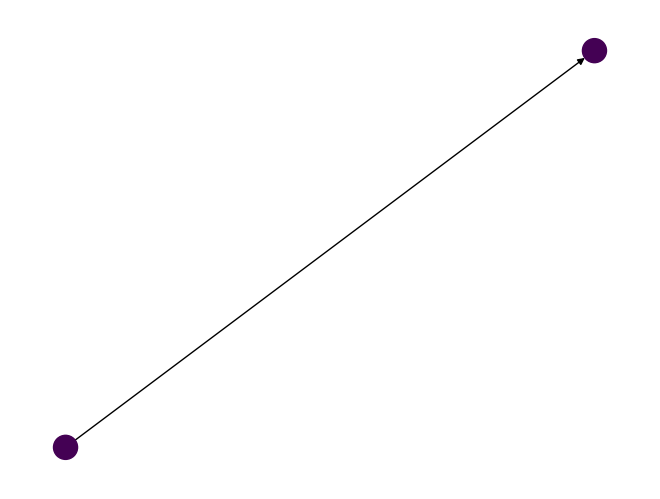

In [8]:
znflow.draw(dag)

Another way of connecting Nodes is through `znflow.DiGraph().write_graph`.
It is important to mention, that we can not use `node1.outputs` here, because we know `node1.outputs is None`. Therefore, we have to replace it by `node1 @ "outputs"`

In [9]:
node1 = Node(inputs=25)
node2 = Node(inputs=node1 @ "outputs")
print(f"{node1.outputs = }")
print(f'{node1 @ "outputs" = }')
print(f"{node2 = }")

node1.outputs = None
node1 @ "outputs" = NodeConnector(attribute='outputs', graph=<None>, node=Node(inputs=25, outputs=None))
node2 = Node(inputs=NodeConnector(attribute='outputs', graph=<None>, node=Node(inputs=25, outputs=None)), outputs=None)


In [10]:
dag = znflow.DiGraph()
dag.write_graph(node1, node2)

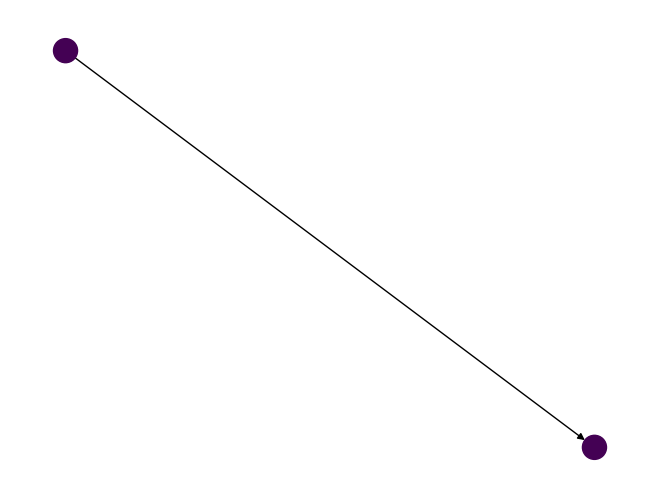

In [11]:
znflow.draw(dag)

# Run the Graph

First let's build some more interesting graphs:

In [12]:
class SumNodes(znflow.Node):
    inputs = znflow.EdgeAttribute()
    outputs = znflow.EdgeAttribute(None)
    
    def _post_init_(self):
        self._id_ = self.__repr__()

    def run(self):
        self.outputs = sum(self.inputs)

In [13]:
with znflow.DiGraph() as dag:
    node1 = Node(inputs=5)
    node2 = Node(inputs=10)
    node3 = Node(inputs=node1.outputs)
    node4 = Node(inputs=node2.outputs)
    node5 = SumNodes(inputs=[node3.outputs, node4.outputs])
    node6 = SumNodes(inputs=[node2.outputs, node5.outputs])
    node7 = SumNodes(inputs=[node6.outputs])

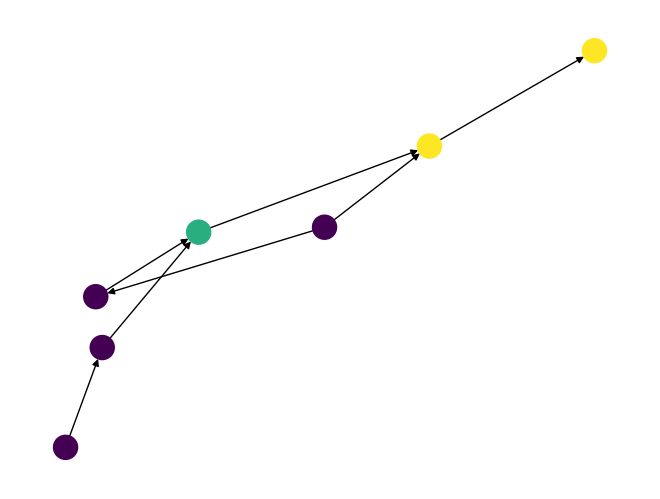

In [14]:
znflow.draw(dag)

In [15]:
dag.run() # default is to call node.run()
dag.nodes

NodeView((Node(inputs=5, outputs=10), Node(inputs=10, outputs=20), Node(inputs=10, outputs=20), Node(inputs=20, outputs=40), SumNodes(inputs=[20, 40], outputs=60), SumNodes(inputs=[20, 60], outputs=80), SumNodes(inputs=[80], outputs=80)))

Or even more nested

In [16]:
import random
k = 3
j = 3
i = 3

with znflow.DiGraph() as dag:
    kdx_nodes = []
    for kdx in range(k):
        jdx_nodes = []
        for jdx in range(j):
            idx_nodes = []
            for idx in range(i):
                idx_nodes.append(Node(inputs=random.random()))
            jdx_nodes.append(SumNodes(inputs=[x.outputs for x in idx_nodes]))
        kdx_nodes.append(SumNodes(inputs=[x.outputs for x in jdx_nodes]))
            
    end_node = SumNodes(inputs=[x.outputs for x in kdx_nodes])

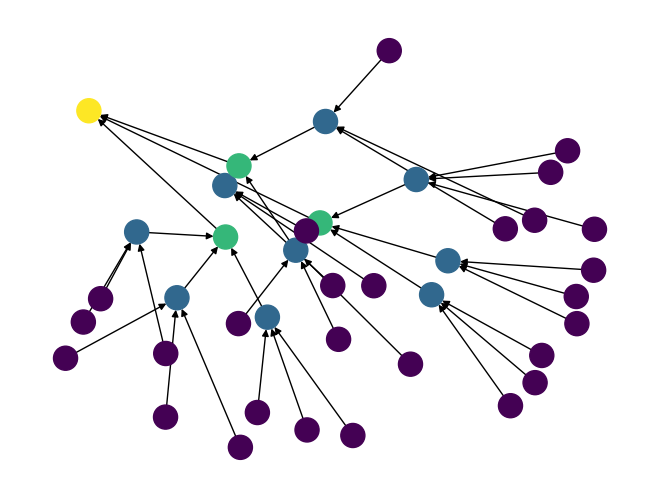

In [17]:
# nx.draw(dag)
znflow.draw(dag)

In [18]:
%time dag.run() # default is to call node.run()
# # [x._id_ for x in dag.nodes]
[x for x in dag.nodes]

CPU times: user 116 ms, sys: 3.84 ms, total: 120 ms
Wall time: 116 ms


[Node(inputs=0.6080030827787968, outputs=1.2160061655575936),
 Node(inputs=0.43751945140248805, outputs=0.8750389028049761),
 Node(inputs=0.22749512132618555, outputs=0.4549902426523711),
 SumNodes(inputs=[1.2160061655575936, 0.8750389028049761, 0.4549902426523711], outputs=2.5460353110149407),
 Node(inputs=0.3002902162039839, outputs=0.6005804324079678),
 Node(inputs=0.45772019302677935, outputs=0.9154403860535587),
 Node(inputs=0.16251589024145774, outputs=0.3250317804829155),
 SumNodes(inputs=[0.6005804324079678, 0.9154403860535587, 0.3250317804829155], outputs=1.841052598944442),
 Node(inputs=0.02310631088929105, outputs=0.0462126217785821),
 Node(inputs=0.4643510867903765, outputs=0.928702173580753),
 Node(inputs=0.8653110660845544, outputs=1.7306221321691089),
 SumNodes(inputs=[0.0462126217785821, 0.928702173580753, 1.7306221321691089], outputs=2.7055369275284438),
 SumNodes(inputs=[2.5460353110149407, 1.841052598944442, 2.7055369275284438], outputs=7.0926248374878265),
 Node(inp